In [3]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import shutil
import utils

In [37]:
image_path = "./content/test4.png"

image_org_gray = cv2.cvtColor(cv2.imread(image_path,cv2.IMREAD_COLOR),cv2.COLOR_BGR2GRAY)

img_blur = cv2.GaussianBlur(image_org_gray, (5, 5), 0)
med_val  = np.median(img_blur)
sigma = 0.33
min_val = int(max(0, (1.0 - sigma) * med_val))
max_val = int(max(255, (1.0 + sigma) * med_val))
img_edge1 = cv2.Canny(image_org_gray, threshold1 = min_val, threshold2 = max_val)



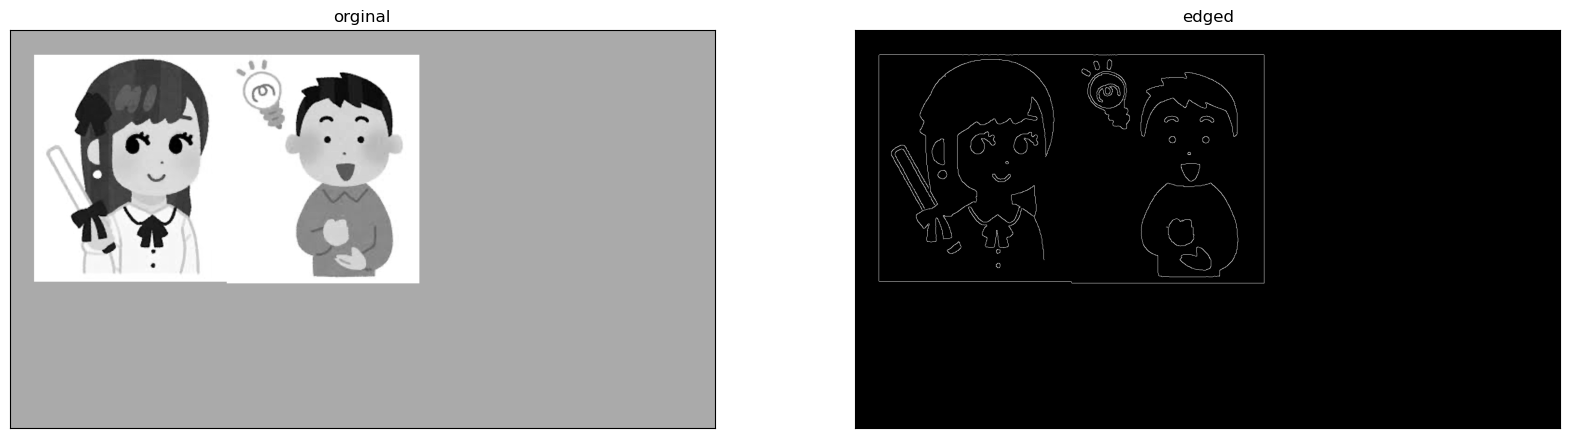

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20), sharex=True, sharey=True)
ax[0].imshow(image_org_gray, cmap='gray')
ax[0].set_title('orginal')
ax[1].imshow(img_edge1, cmap='gray')
ax[1].set_title('edged')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.show()



In [32]:
image_path = "./content/test.png"

img_original = cv2.imread(image_path,cv2.IMREAD_COLOR) #import image
img_gray = cv2.cvtColor(img_original,cv2.COLOR_BGR2GRAY) #change to gray scale

img_blur = cv2.GaussianBlur(img_gray, (131,131), 0) #add Gaussian Blur

_, threshold_img = cv2.threshold(img_blur, 248, 255, cv2.THRESH_BINARY)  #change to binary

reversal_img = cv2.bitwise_not(threshold_img) # reverse white and black

contours, _ = cv2.findContours(reversal_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #get edges

img_with_contours = np.copy(img_gray)
cv2.drawContours(img_with_contours, contours, -1, (0, 255 ,0), 5)
img_with_bb = np.copy(img_gray)
list_bb = []

# ディレクトリを空にする関数
def clear_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)  # ディレクトリを削除
    os.makedirs(directory)  # 再作成

    
# バウンディングボックスごとに切り出して分類・保存
output_dir_images = "./output_images"
output_dir_text = "./output_text"
os.makedirs(output_dir_images, exist_ok=True)
os.makedirs(output_dir_text, exist_ok=True)
clear_directory(output_dir_images)
clear_directory(output_dir_text)

for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    if w*h < 2000:
        continue
    cv2.rectangle(img_with_bb, (x, y), (x + w , y + h), (0,255, 0), 3)
    list_bb.append([x,y,w,h])

    
    cropped_img = img_original[y:y+h, x:x+w]  # 切り出す
    
    # マスクを作成して余白を白で埋める
    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(mask, [contour - [x, y]], -1, 255, thickness=cv2.FILLED) 
    result_img = np.ones_like(cropped_img, dtype=np.uint8) * 255  # 白い背景画像を作成
    result_img[mask == 255] = cropped_img[mask == 255]  # マスク領域のみ元画像を貼り付け
    
    
    if w/h < 2: 
        save_path = os.path.join(output_dir_images, f"region_{i}.jpg")
    else:  # それ以外は「テキストのみ」と分類
        save_path = os.path.join(output_dir_text, f"region_{i}.jpg")
    
    cv2.imwrite(save_path, result_img)



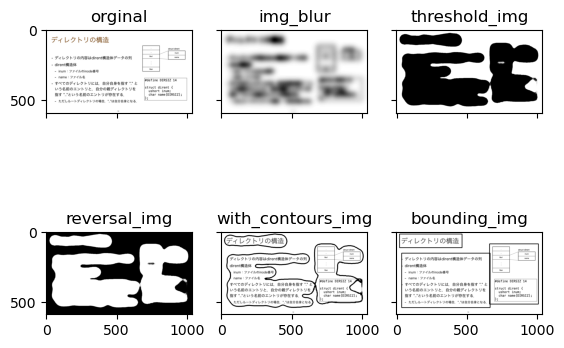

In [33]:
fig, ax = plt.subplots(2,3, sharex=True, sharey=True)
ax[0,0].imshow(img_original, cmap='gray')
ax[0,0].set_title('orginal')
ax[0,1].imshow(img_blur, cmap='gray')
ax[0,1].set_title('img_blur')
ax[0,2].imshow(threshold_img, cmap='gray')
ax[0,2].set_title('threshold_img')
ax[1,0].imshow(reversal_img, cmap='gray')
ax[1,0].set_title('reversal_img')
ax[1,1].imshow(img_with_contours, cmap='gray')
ax[1,1].set_title('with_contours_img')
ax[1,2].imshow(img_with_bb, cmap='gray')
ax[1,2].set_title('bounding_img')
plt.show()

In [4]:
def save_image_cropped(image_path: str, output_dir: str = "./outputs"):
    """
    Function to process an image by detecting contours, cropping regions, and saving them to specified directories.
    
    Parameters:
    - image_path (str): Path to the input image to be processed.
    - output_images_dir (str): Directory to save cropped image regions (default is './outputs').
    
    Returns:
    - None: The function saves cropped images into the specified directories.
    """
    # Import the image and convert it to grayscale
    img_original = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)

    # Convert to binary image using thresholding
    _, img_gray = cv2.threshold(img_gray, 248, 255, cv2.THRESH_BINARY)

    # Apply Gaussian Blur to reduce noise
    img_blur = cv2.GaussianBlur(img_gray, (401, 401), 0)

    # Convert to binary image using thresholding
    _, threshold_img = cv2.threshold(img_blur, 248, 255, cv2.THRESH_BINARY)

    # Invert the image (swap black and white)
    reversal_img = cv2.bitwise_not(threshold_img)

    # Find contours from the binary image
    contours, _ = cv2.findContours(reversal_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Copy the grayscale image to draw contours and bounding boxes
    img_with_contours = np.copy(img_gray)
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 5)
    img_with_bb = np.copy(img_gray)
    list_bb = []


    # Create directories for saving cropped images and text-only regions
    utils.clear_directory(output_dir)

    # Loop through each contour, extract bounding boxes, and classify
    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)

        # Skip small regions based on area
        if w * h < 2000:
            continue
        
        # Draw bounding boxes on the image
        cv2.rectangle(img_with_bb, (x, y), (x + w, y + h), (0, 255, 0), 3)
        list_bb.append([x, y, w, h])

        # Crop the region from the original image
        cropped_img = img_original[y:y+h, x:x+w]

        # Create a mask and fill the contour area with white
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.drawContours(mask, [contour - [x, y]], -1, 255, thickness=cv2.FILLED)

        # Create a white background image
        result_img = np.ones_like(cropped_img, dtype=np.uint8) * 255
        # Apply the mask to only keep the original image content within the contour
        result_img[mask == 255] = cropped_img[mask == 255]

        # Save to the appropriate folder

        save_path = os.path.join(output_dir, f"region_{i}.jpg")


        # Save the resulting image
        #cv2.imwrite(save_path, result_img)
    fig, ax = plt.subplots(2,3, sharex=True, sharey=True)
    ax[0,0].imshow(img_original, cmap='gray')
    ax[0,0].set_title('orginal')
    ax[0,1].imshow(img_blur, cmap='gray')
    ax[0,1].set_title('img_blur')
    ax[0,2].imshow(threshold_img, cmap='gray')
    ax[0,2].set_title('threshold_img')
    ax[1,0].imshow(reversal_img, cmap='gray')
    ax[1,0].set_title('reversal_img')
    ax[1,1].imshow(img_with_contours, cmap='gray')
    ax[1,1].set_title('with_contours_img')
    ax[1,2].imshow(img_with_bb, cmap='gray')
    ax[1,2].set_title('bounding_img')
    plt.show()


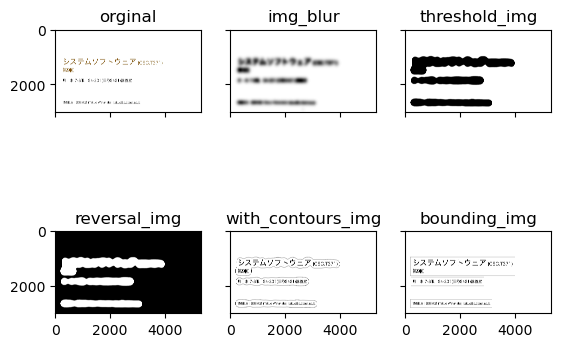

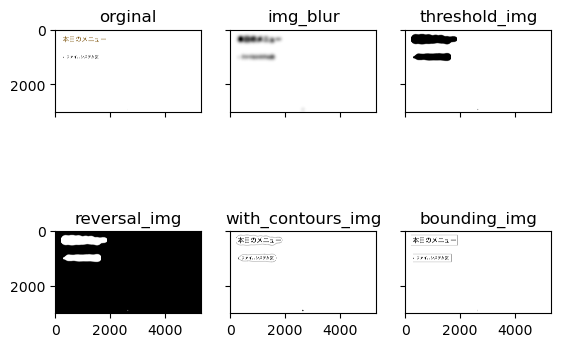

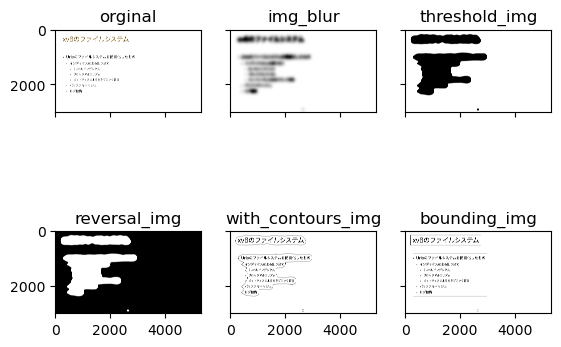

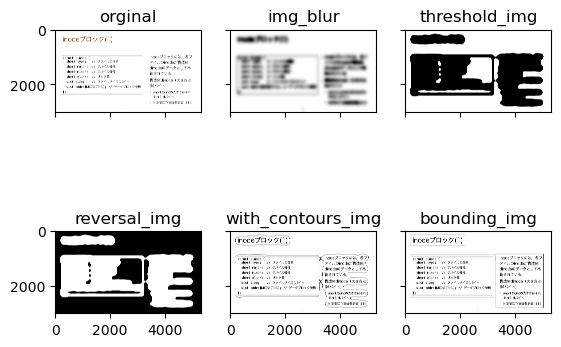

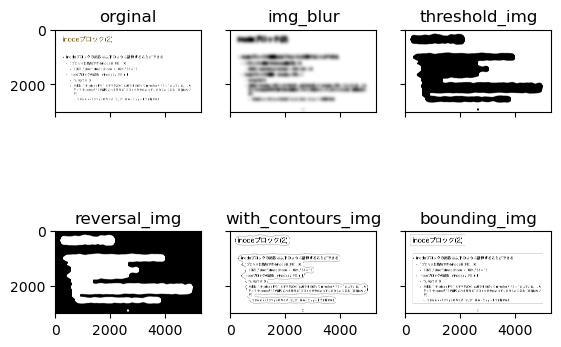

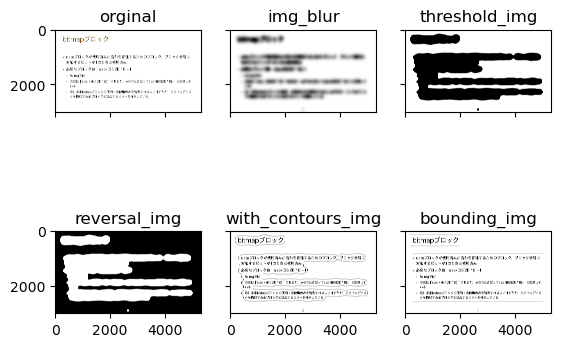

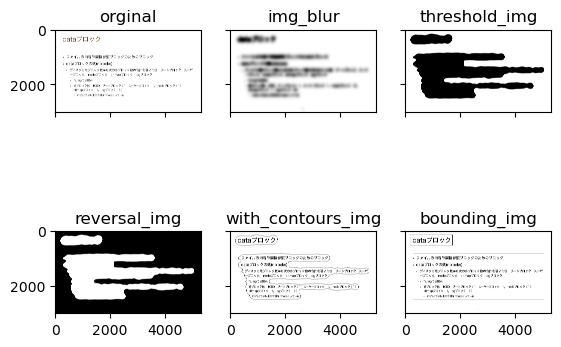

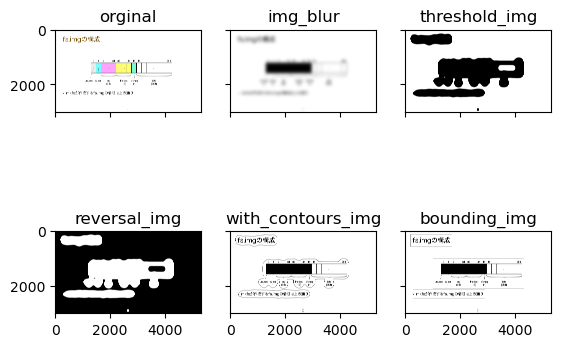

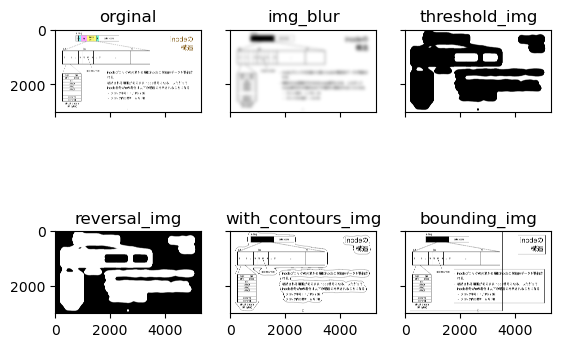

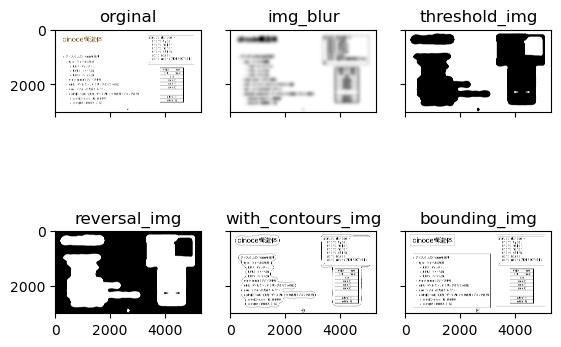

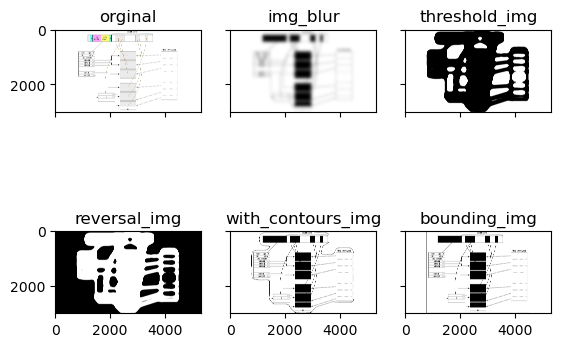

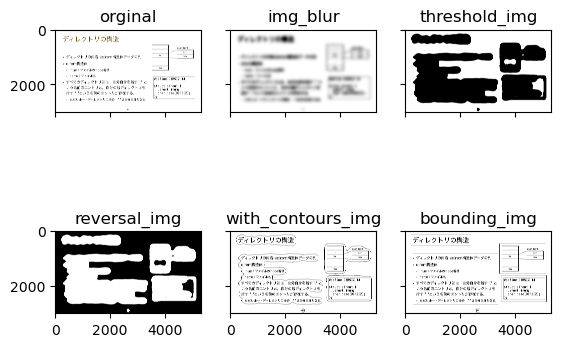

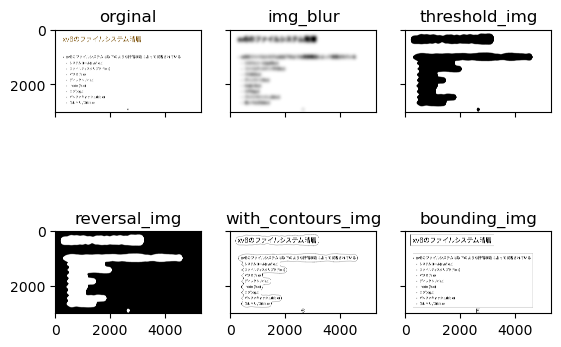

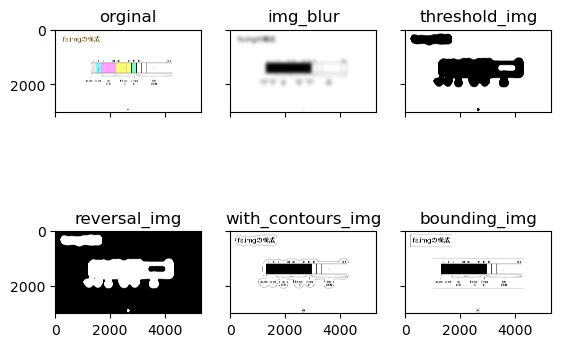

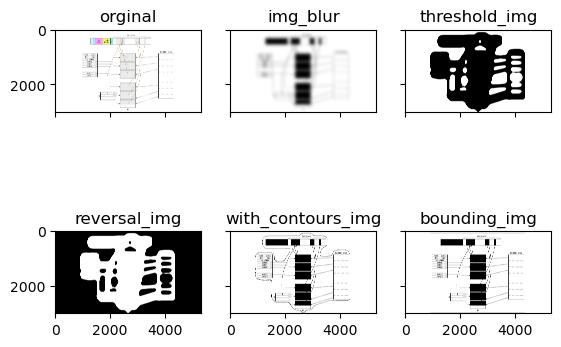

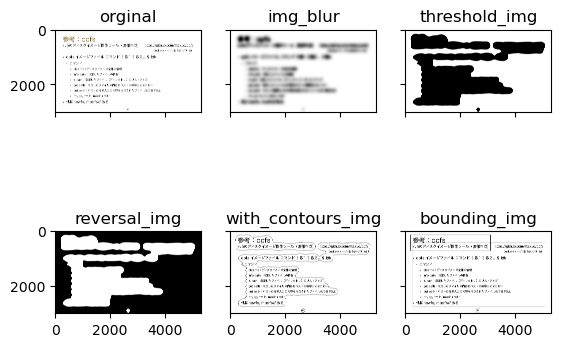

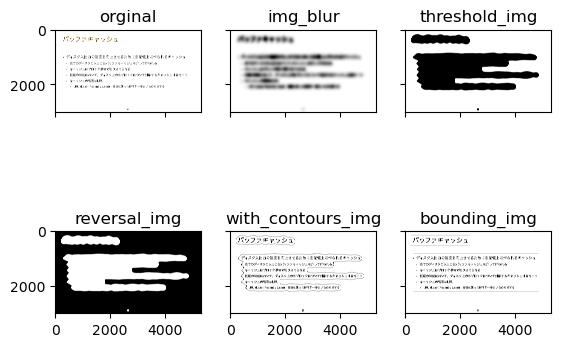

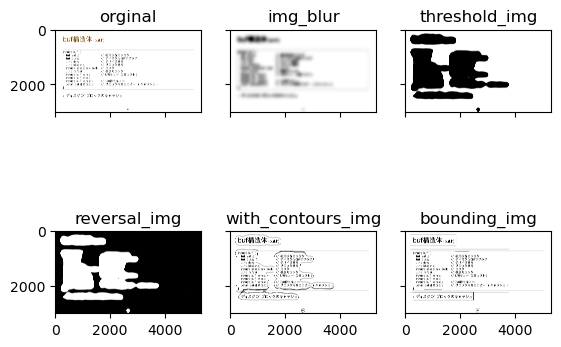

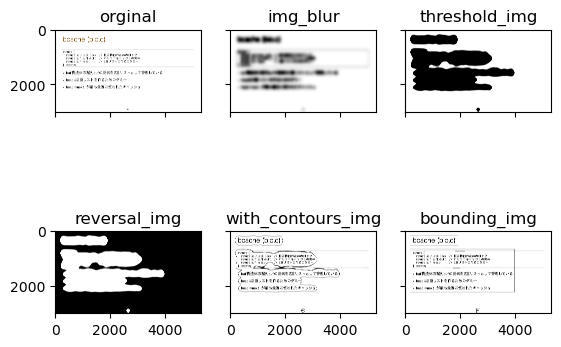

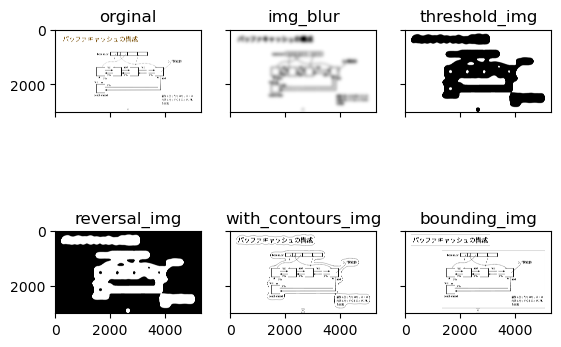

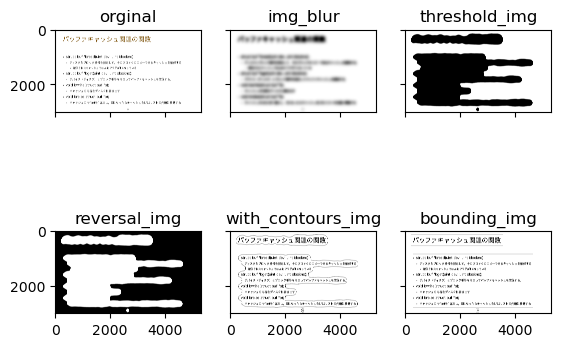

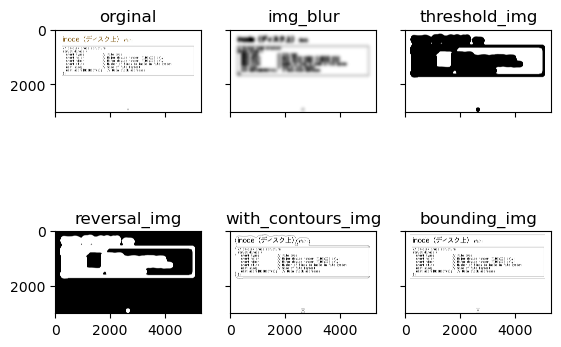

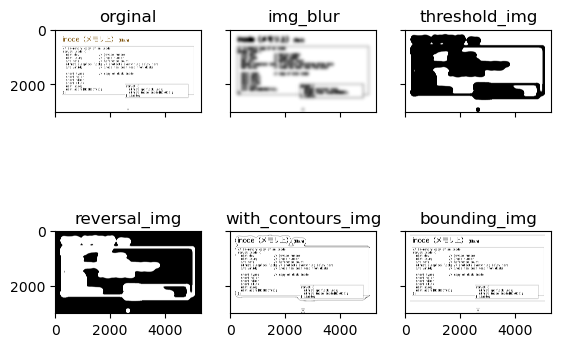

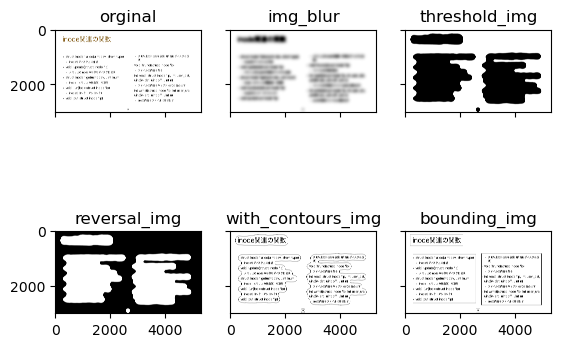

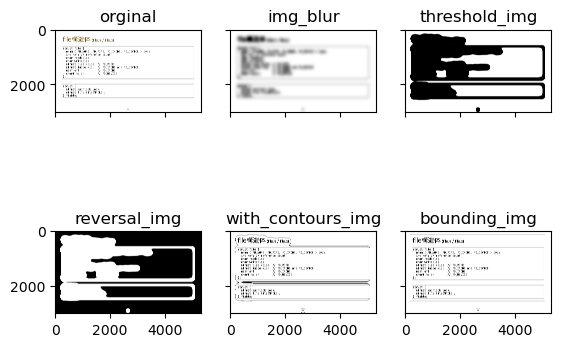

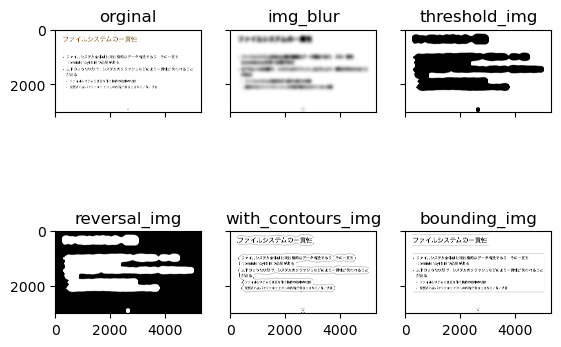

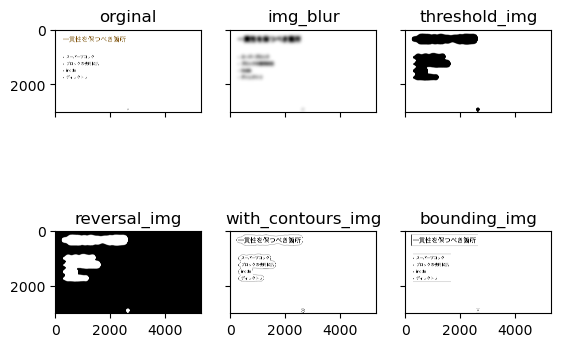

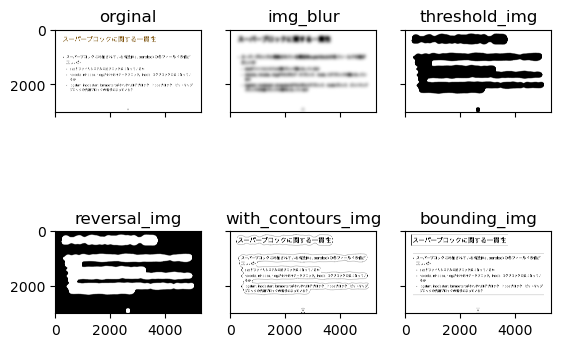

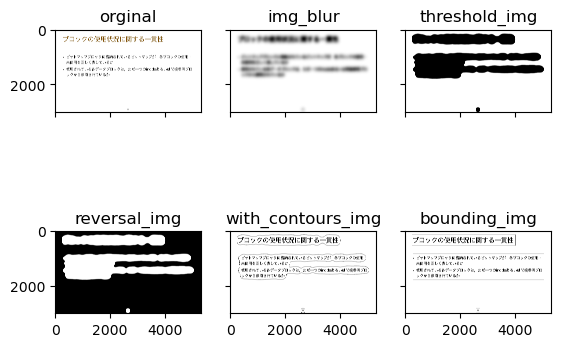

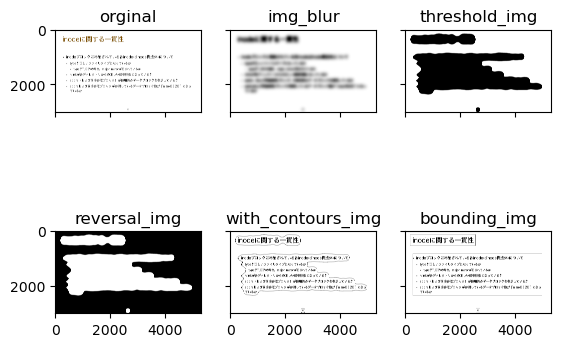

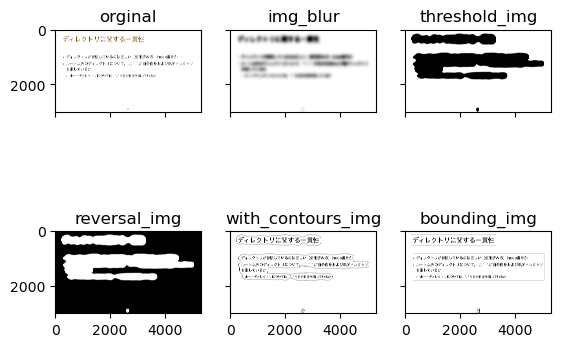

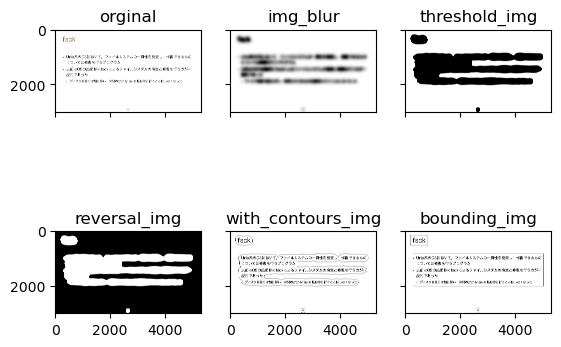

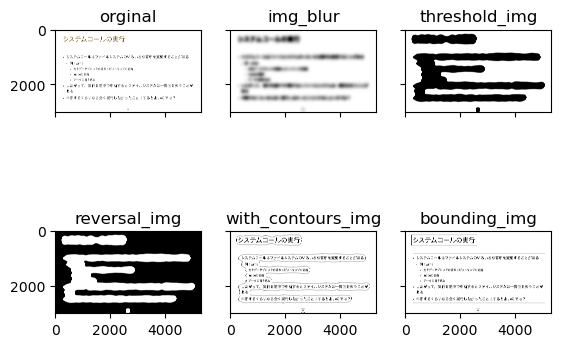

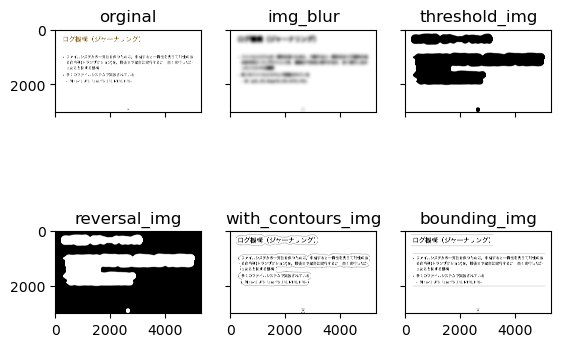

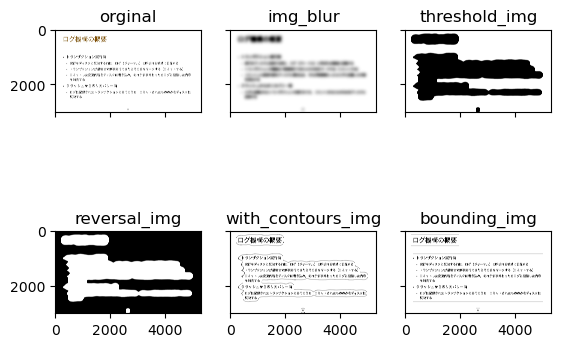

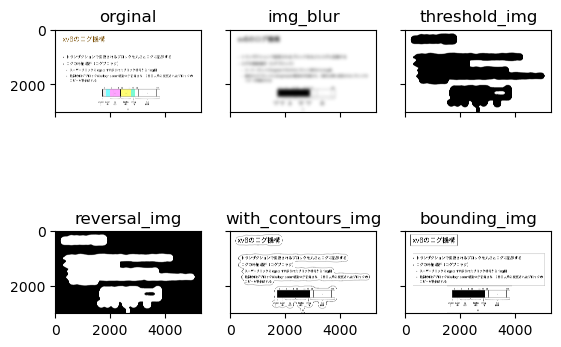

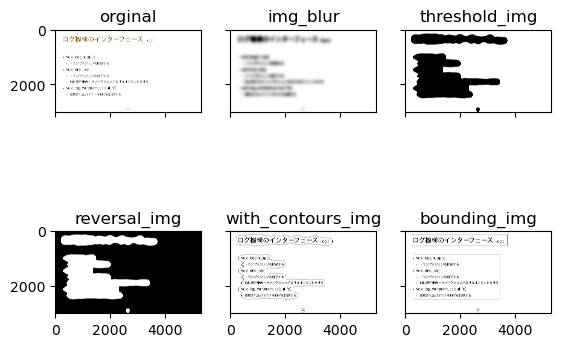

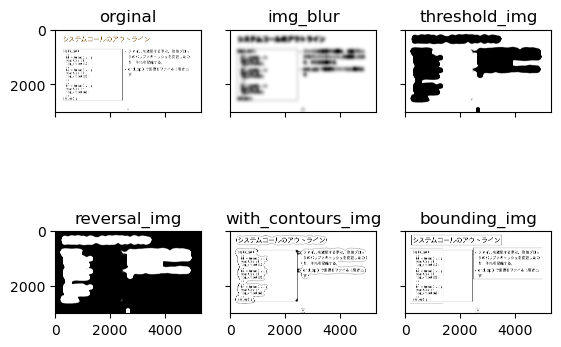

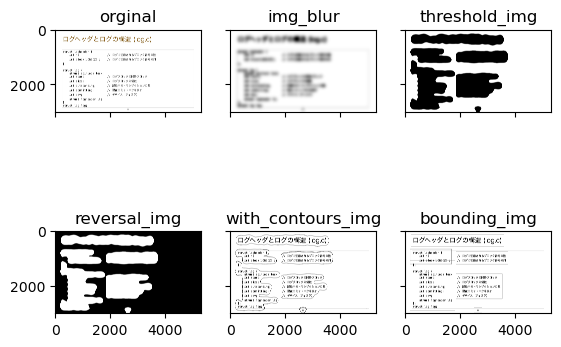

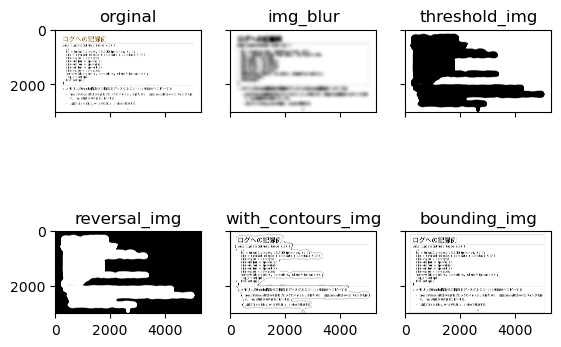

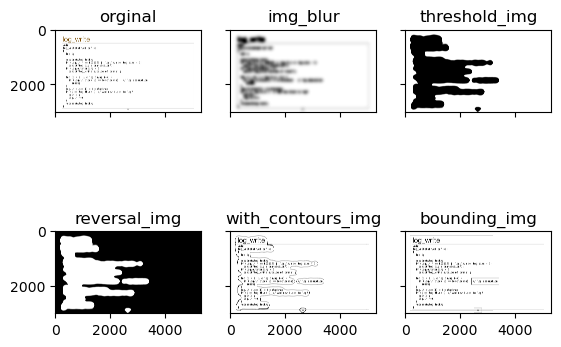

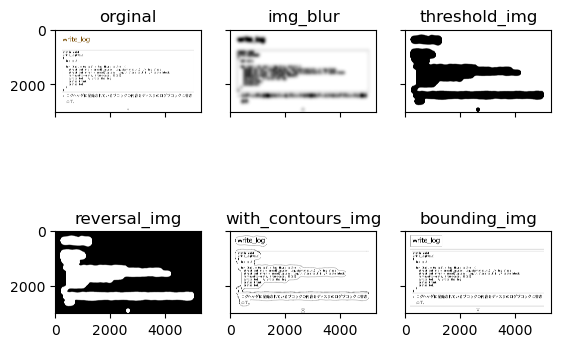

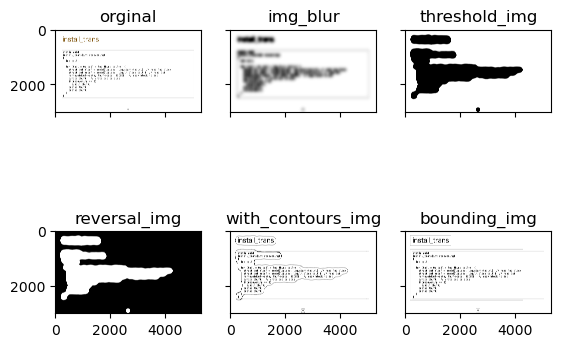

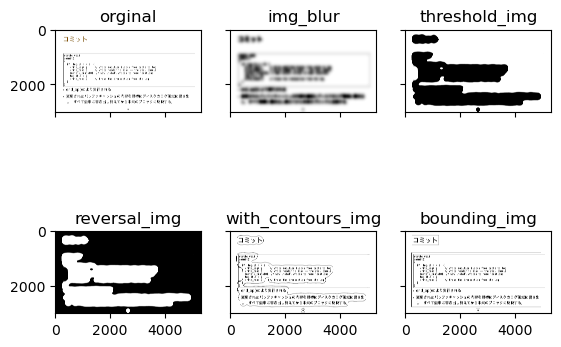

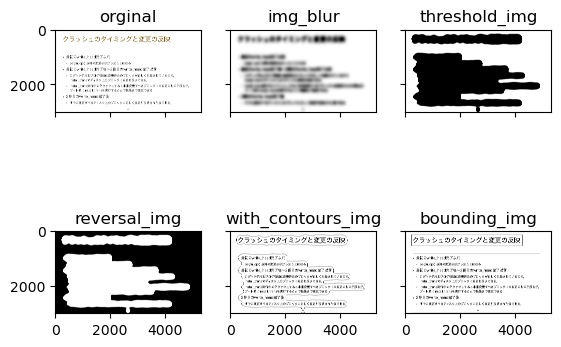

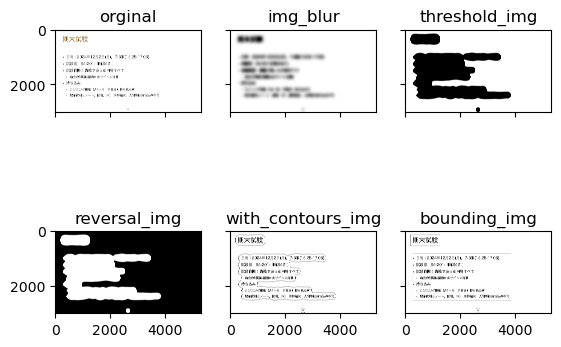

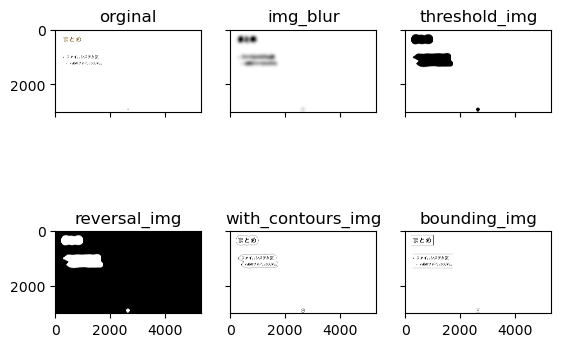

In [13]:
for i in range(1,48):
    save_image_cropped(f'./image_from_pdf/test-{i}.jpeg')